In [234]:
from __future__ import division
%pylab inline
import pandas as pd
import os
import json
from collections import defaultdict, Counter
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [554]:
def getCDF(data):
    xdata = np.sort(data)
    ydata = [i/len(xdata) for i in range(len(xdata))]
    return xdata, ydata

# 1. Number of sites per CDN and ASN

In [235]:
df_all = pd.read_pickle('output/df_sites.pkl')
df_asn_cdn = pd.read_pickle('output/df_asn_cdn.pkl')
df_site_cdn_method_map = pd.read_pickle('output/df_site_cdn_method_map.pkl')

In [236]:
df_asn_cdn.head()

,rank,site,IP,ASN,cdn_parsed,cdn_whois,cdn
0,1,google.com,172.217.160.238,15169,Google,Google,Google
1,2,youtube.com,172.217.31.14,15169,Google,Google,Google
2,3,facebook.com,157.240.25.35,32934,Facebook,Facebook,Facebook
3,4,baidu.com,123.125.115.110,4808,False,False,False
4,5,wikipedia.org,103.102.166.224,14907,False,False,False


## 1a. ASN Analysis
- Rank ASNs by number of sites

### Domain to IP and ASN
- use socket.gethostaddr() to get IP for domain
- use pyasn to get ASN (there are many methods and libraries to do this, pyasn lets you download routviews data)
- 480 of 500 websites are resolved to an IP address. We will be using these reachable sites in our analysis.

- Unreachable sites:
    - 20 websites are blocked either directly by ISP (porn, adware, etc.)
    - or we can't reach them due to bad DNS resolution/permissions (googleusercontent.com, cloudfront.net, etc.)

In [1060]:
bad_sites = list(df_all[ ( df_all['IP'] == False ) ]['site'])
print("List of bad/unreachable sites: ", bad_sites)

List of bad/unreachable sites:  ['pornhub.com', 'ok.ru', 'livejasmin.com', 'xvideos.com', 'googleusercontent.com', 'xhamster.com', 'exosrv.com', 'xnxx.com', 'chaturbate.com', 'yts.am', 'youporn.com', '1337x.to', 'cloudfront.net', 'redtube.com', 'rutracker.org', 'banvenez.com', 'bp.blogspot.com', 'exdynsrv.com', 'sex.com', 'wixsite.com']


### Domains per ASN

#### There are 190 unique ASNs serving 480 websites of the Alexa top 500.
- <font color = 'red'>231 websites are served by 8 ASNs: Google (15169: 69 sites), ? (13335: 38 sites), Amazon AWS (16509: 36 sites), ? (54113: 30 sittes), Akamai (16625: 17 sites), Amazon AWS (14618: 17 sites), ? (37963: 13 sites), (4808: 11 sites)</font>
- 37 ASNs serve 104 websites with each serving less than 10 but more than one.
- 145 ASNs serve a website each.

#### <font color = 'red'>There are x unique AS names</font>
- TODO



In [238]:
num_sites_per_asn = df_asn_cdn.groupby([ 'ASN'])['rank'].count().sort_values(ascending = False)
many_sites = num_sites_per_asn[ num_sites_per_asn > 1]

In [239]:
print("Number of ASNs serving 480 sites of Alexa top 500 = ", len(num_sites_per_asn))

print("\nNumber of ASNs serving only one site each = ", len( num_sites_per_asn[ (num_sites_per_asn <= 1)] ))

print("\nNumber of ASNs serving more than one site but less than 10 = ", len( many_sites[many_sites < 10] ))
print("Number of sites served by above 37 ASNs == ", sum( many_sites[many_sites < 10] ))
                                                                                       
print("\nNumber of ASNs serving 10 or more websites each = ", len(many_sites[many_sites>=10]))
print("Number of sites served by above top 8 ASNs = ", sum(many_sites[many_sites>=10]))

print("\nTop ASNs catering to 10 or more websites each, and number of websites: ", end="")
print(many_sites[many_sites>10].to_dict())


Number of ASNs serving 480 sites of Alexa top 500 =  190

Number of ASNs serving only one site each =  145

Number of ASNs serving more than one site but less than 10 =  37
Number of sites served by above 37 ASNs ==  104

Number of ASNs serving 10 or more websites each =  8
Number of sites served by above top 8 ASNs =  231

Top ASNs catering to 10 or more websites each, and number of websites: {15169: 69, 13335: 38, 16509: 36, 54113: 30, 16625: 17, 14618: 17, 37963: 13, 4808: 11}


# TODO

In [240]:
# TODO
# import pyasn
# as_name_file = ??
# asndb = pyasn.pyasn('data/...', as_name_file)
# df_asn_cdn['AS_name'] = df_asn_cdn['ASN'].apply(asndb.get_as_name)
# df_asn_cdn.groupby(['AS_name'])['rank'].count().sort_values(ascending = False)

## 1b. CDN Analysis
- Filter the domains served by a CDN
- Rank CDN providers by number of sites

### Domain to CDN
- Use a CDN names list from wikipedia and various websites
- Use a CDN domains list from github that maps certain urls to the CDN served
- Three methods are used to finally determine the CDN used by the site (code in find_cdn_methods.py) 
    1. Check if site itself is well known CDN by comparing it to CDN names and CDN domains
    2. Counting sources on site:
        - Download and parse the site homepage (using requests and BeautifulSoup) and find the url sources of static objects (images and scripts) as well as links on the webpage.
        - Count objects per source url, and find the url with maximum or substantial traffic.
        - Compare url to well known CDN domains. If it can't be resolved.
    3. Parsing organization information for whois:
        - Most websites have CDN provider in the whois information since their publically resolved IPs belong to the CDN
        - Compare 'Organization' tag in whois to popular CDN names.
- At times, method 2 gives us a certain cdn url with many static object (for ex: twitchcdn.net for twitch.tv) while the whois tells us which CDN the site uses (ex: Fastly for twitch.tv). This allows us to associate the cdn url or domain with the CDN name to populate our CDN_domain dictionary for future testing.

### Details of CDN finding algorithm
# <font color='red'> TODO </font>




- Minor improvements to algorithm:
    - HTTP header may contain CDN name in fields 'Server','x-cdn', or 'x-cache'
    - "host site" returns IP addresses, but sometimes also returns server names containing CDN name
    - if returned server names dont have CDN name, we can still request the page being pointed to. For response code 500 the page may contain the name of CDN
    - Another simple way is to append "cdn." keyword to the site and try to see if this host exists (use host -a)
    - 

In [293]:
df_asn_cdn[ df_asn_cdn['cdn']=='daumcdn.net' ]

,rank,site,IP,ASN,cdn_parsed,cdn_whois,cdn
153,154,daum.net,211.231.99.80,38099,daumcdn.net,False,daumcdn.net
291,292,tistory.com,211.231.108.151,38099,daumcdn.net,False,daumcdn.net


### Domains per CDNs
#### 134 of 480 valid sites were not using CDNs.
- The organization name in the whois record of these sites was either the site name itself or a hosting service that is not commonly known as a CDN provider.
- Majority of static resources (images and scripts) were either hosted locally (instead of externally on a separate domain), or they were hosted on multiple domains. So we could not confirm a single domain or url carrying most of the traffic when loading the home page.


#### 346 sites were using 101 (unconfirmed) CDNs. Of these 34 are confirmed and known CDNs while 66 are suspected CDNs.

#### CONFIRMED: 34 CDNs were confirmed resolved to known CDNs from an offline list of CDN names and popular CDN domains. These 34 CDNs catered to 279 of 480 sites.
- 4 of 34 known CDNs correspond to sites hosted on Amazon services counted individually (based on the returned whois records and urls: ['Amazon Technologies Inc.', 'Amazon AWS', 'Amazon.com, Inc.', 'Amazon CloudFront']). We have assumed that sites using Amazon hosting services are also using Cloudfront as their CDN (this may not be true in reality). Total sites catered by Amazon's 4 CDNs is 54.
- 5 major CDNs with a large market share are ['Google', 'Cloudflare', 'Alibaba', 'Fastly', 'Akamai']. Total sites catered by these 5 major CDN providers is 180. Including Amazon, 234 sites were confirmed using these 6 major CDNs.
- Total sites catered by 25 other known CDN providers (including 'MaxCDN', 'Edgecast', 'Open-Connect', etc.) is 45. Some of these popular CDNs, such as 'Open-Connect', only cater to a single popular domain (netflix.com). Others (like Incapsula) cater to multiple sites (prothomalo.com, kooora.com) that are too low on the Alexa ranking.

#### UNCONFIRMED: 66 URLs hosted majority of static objects (images and scripts) on the home page of the site. This behavior may indicate that it is a CDN, or it may be a static address that is not the same as the site we are checking. Of 66, only 'daumcdn.net' catered to two websites ('daum.net', 'tistory.com'), bringing the total to 67 sites.
- We decided that there is a higher chance of such urls being a CDN if the url itself contains the string 'cdn'. Since this is not a confirmed method, we will continue the timing analysis of all 66 URLs considering them as unknown CDNs.
- 37 of 66 URLs contained the string 'cdn', catering to 38 websites. For example: 'assets-cdn.github.com', 'cdn2.tstatic.net', 'line-scdn.net', etc.
- 29 of 66 URLs do not contain the string 'cdn' and have a higher chance of being a static domain that doesn't match the site domain name and doesn't have a well known 'Organization' name in its whois. These 29 CDNs served 29 websites individually. This list contained 'www.googleadservices.com' (cobalten.com) and 'cfl.dropboxstatic.com' (dropbox.com), indicating that a majority of resources on these websites were hosted on the two URLs. While cobalten.com is not on Google Cloud, dropbox.com has a high chance of utilizing CDNs. Since this can't be confirmed we're analyzing all such sites with the assumption that they are on CDNs.


In [324]:
num_sites_per_cdn = df_asn_cdn.groupby('cdn')['rank'].count().sort_values(ascending=False)

print("Number of sites estimated not using CDNs = ", num_sites_per_cdn[False])
print("Total number of CDNs (unconfirmed) = ", len(num_sites_per_cdn))
print("Number of sites estimated using CDNs = ", (sum(num_sites_per_cdn) - num_sites_per_cdn[False]) )

Number of sites estimated not using CDNs =  134
Total number of CDNs (unconfirmed) =  101
Number of sites estimated using CDNs =  346


In [325]:
known_cdn = {}
unknown_cdn = {}
sum_dict = lambda v: sum([x for x in v.values() ])

for n, i in num_sites_per_cdn.items():
    if n:
        if n.lower() != n:
            # if some letters are capital, it should be resolved CDN.
            known_cdn[n] = i
        else:
            # very simple check for url: all letters are not capitalized.
            unknown_cdn[n] = i

print( "Number of known and resolved CDNs (based on whois and well known names): %s" %len(known_cdn) )
print( "Number of websites served by known and resolved CDNs: %s" % (sum_dict(known_cdn)) )

print("Number of unresolved or unknown URLs that seem like CDNs: %s" % (len(unknown_cdn)) )
print("Number of websites served by unresolved or unknown URLs that seem like CDNs: %s" % (sum_dict(unknown_cdn)) )

print("\nList of known CDNs and number of websites:\n\n", known_cdn)

print("\n\nList of unknown URLs that may or may not be CDNs:\n\n", list( unknown_cdn.keys()) )


Number of known and resolved CDNs (based on whois and well known names): 34
Number of websites served by known and resolved CDNs: 279
Number of unresolved or unknown URLs that seem like CDNs: 66
Number of websites served by unresolved or unknown URLs that seem like CDNs: 67

List of known CDNs and number of websites:

 {'Google': 70, 'Cloudflare': 39, 'Amazon Technologies Inc.': 32, 'Fastly': 30, 'Akamai': 29, 'Alibaba': 12, 'Amazon AWS': 12, 'Amazon.com, Inc.': 6, 'Microsoft': 5, 'Yahoo': 5, 'OVH': 4, 'Facebook': 4, 'Amazon CloudFront': 4, 'Twitter': 3, 'Incapsula': 2, 'LinkedIn CDN': 2, 'SoftLayer': 2, 'ChinaNetCenter': 2, 'Open-Connect (Netflix)': 1, 'WordPress': 1, 'Taobao': 1, 'StackPath': 1, 'Sohu': 1, 'Reflected Networks': 1, 'Orange': 1, 'Level 3': 1, 'Internap': 1, 'Instart Logic': 1, 'Hola': 1, 'HiNet': 1, 'Edgecast': 1, 'Comcast': 1, 'ChinaCache': 1, 'jsDelivr': 1}


List of unknown URLs that may or may not be CDNs:

 ['daumcdn.net', 'c5.rgstatic.net', 'awscdn.detik.net.id',

In [327]:
# simplistic logic to separate unknown sites
unknown_cdn_cnt = 0
unknown_url_cnt = 0

for n in unknown_cdn.keys():
    if 'cdn' in n:
        unknown_cdn_cnt += 1
    #elif n in ['aws.amazon.com', 'www.googleadservices.com']:
    #    known_cdn_cnt += 1
    else:
        unknown_url_cnt += 1
        #print (n)
        
print("Unknown CDNs based on url (contain string 'cdn'): %s\nUnknown urls that might not be CDNs: %s" \
      % (unknown_cdn_cnt, unknown_url_cnt))

df_asn_cdn[ df_asn_cdn['cdn'].isin( ['cfl.dropboxstatic.com', 'www.googleadservices.com'] ) ]

Unknown CDNs based on url (contain string 'cdn'): 37
Unknown urls that might not be CDNs: 29


,rank,site,IP,ASN,cdn_parsed,cdn_whois,cdn
80,81,dropbox.com,162.125.248.1,19679,cfl.dropboxstatic.com,False,cfl.dropboxstatic.com
150,151,cobalten.com,188.72.213.176,35415,www.googleadservices.com,False,www.googleadservices.com


In [317]:
only_one_site = num_sites_per_cdn[ num_sites_per_cdn <= 1]
many_sites = num_sites_per_cdn[ num_sites_per_cdn > 1]

print("Number of known CDNs (resolved) or URLs catering to majority static objects on one site's homepage:",
      len(only_one_site))

print("\nNumber of sites confirmed using CDNs (multiple sites per CDN) = ", (sum(many_sites) - many_sites[False]))
print("Number of sites using 1 CDN each (only one site per known CDN + 1 url that may be CDNs) = ", sum(only_one_site))

print("\nCDN providers (more than 1 site each) and number of sites:")
print(many_sites[ many_sites.index!=False ])

Number of known CDNs (resolved) or URLs catering to majority static objects on one site's homepage: 81

Number of sites confirmed using CDNs (multiple sites per CDN) =  265
Number of sites using 1 CDN each (only one site per known CDN + 1 url that may be CDNs) =  81

CDN providers (more than 1 site each) and number of sites:
cdn
Google                      70
Cloudflare                  39
Amazon Technologies Inc.    32
Fastly                      30
Akamai                      29
Alibaba                     12
Amazon AWS                  12
Amazon.com, Inc.             6
Microsoft                    5
Yahoo                        5
OVH                          4
Facebook                     4
Amazon CloudFront            4
Twitter                      3
Incapsula                    2
LinkedIn CDN                 2
SoftLayer                    2
daumcdn.net                  2
ChinaNetCenter               2
Name: rank, dtype: int64


In [342]:
# Count sites using 6 major well known CDNs that cater to most of the market

major_known_cdns = ['Google', 'Cloudflare', 'Alibaba', 'Fastly', 'Akamai']
amazon_cdns = ['Amazon Technologies Inc.', 'Amazon AWS', 'Amazon.com, Inc.', 'Amazon CloudFront']

major_cdn_site_cnt = 0
amazon_cdn_site_cnt = 0
other_cdn_cnt = 0
other_cdn_site_cnt = 0
for n, i in known_cdn.items():
    if n in major_known_cdns:
        major_cdn_site_cnt += i
    elif n in amazon_cdns:
        amazon_cdn_site_cnt += i
    else:
        other_cdn_cnt += 1
        other_cdn_site_cnt += i

print("List of Amazon CDN providers as resolved by whois: \n", amazon_cdns)
print("List of major CDN providers with most customer sites (excluding Amazon): \n", major_known_cdns, "\n")

print("Total sites catered by Amazon's %s CDNs is %s" % (len(amazon_cdns), amazon_cdn_site_cnt))
print("Total sites catered by %s other major CDN providers is %s" % (len(major_known_cdns), major_cdn_site_cnt))
print("Total sites catered by %s other known CDN providers is %s" % (other_cdn_cnt, other_cdn_site_cnt))

List of Amazon CDN providers as resolved by whois: 
 ['Amazon Technologies Inc.', 'Amazon AWS', 'Amazon.com, Inc.', 'Amazon CloudFront']
List of major CDN providers with most customer sites (excluding Amazon): 
 ['Google', 'Cloudflare', 'Alibaba', 'Fastly', 'Akamai'] 

Total sites catered by Amazon's 4 CDNs is 54
Total sites catered by 5 other major CDN providers is 180
Total sites catered by 25 other known CDN providers is 45


In [352]:
print("Some popular CDNs catering to a few websites, and deciding their CDNs based on page parsing and whois data")
df_asn_cdn[ df_asn_cdn['cdn'].isin( ['Yahoo', 'Facebook', 'Edgecast', 'Incapsula'] ) ]

Some popular CDNs catering to a few websites, and deciding their CDNs based on page parsing and whois data


,rank,site,IP,ASN,cdn_parsed,cdn_whois,cdn
2,3,facebook.com,157.240.25.35,32934,Facebook,Facebook,Facebook
6,7,yahoo.com,72.30.35.10,26101,Yahoo,Yahoo,Yahoo
18,19,instagram.com,52.45.71.129,14618,Facebook,Amazon Technologies Inc.,Facebook
28,29,yahoo.co.jp,183.79.135.206,24572,Yahoo,Yahoo,Yahoo
79,80,fbcdn.net,157.240.13.35,32934,Facebook,Facebook,Facebook
230,231,messenger.com,157.240.13.14,32934,False,Facebook,Facebook
323,324,tripadvisor.com,192.229.162.112,15133,tacdn.com,Edgecast,Edgecast
350,351,aol.com,106.10.218.150,56173,aolcdn.com,Yahoo,Yahoo
403,404,flickr.com,69.147.88.7,36088,Yahoo,Yahoo,Yahoo
445,446,prothomalo.com,107.154.248.36,19551,paloimages.prothom-alo.com,Incapsula,Incapsula


## 1c. Association between CDN and ASN/AS name

In [203]:
# TODO

## 1d. Conclusion of CDN and ASN analysis


# 2. Site timings per CDN

## 2a. Extracting timings using curl

- Use curl to query top 500 websites 100 times. Extract individual timings for received packets (see https://ec.haxx.se/usingcurl-verbose.html). Calculate required timing data.
    - t_dns = time for DNS resolution (no redirects) = time_namelookup - time_redirect  
    - t_tcp = time for TCP connection (SYN/SYNACK) = time_connect - time_namelookup  
    - t_ssl = time for SSL handshake (only if https) = time_appconnect - time_connect  
    - t_fbyte = time_starttransfer
    - t_wait = time between issuing GET request and first byte received (server calculation time) = time_starttransfer - time_pretransfer  
    - t_rx = time to receive data from first to last byte = time_total - time_starttransfer 
- Sites such as google, reddit, and others on CDNs ban the IP very soon since they are able to detect multiple queries from the same address. Use parallization and ensure that there is a random time interval (1-5 mins) between each query to the same website. Also, change the user-agent string in the request header if needed.

#### Blocked Sites
- 49 of 500 websites were blocked (completely unreachable) when using curl. . As a first step we will remove them from timing analysis.
- Requests to these sites timed out (more than 10s) consistently and we received no response except status codes 0 for all of them.
    - Of these, 18 websites could not be resolved to a host IP address. These include porn and adware sites blocked by the ISP. However, curl is able to successfully reach 2 websites {'googleusercontent.com', 'wixsite.com'} that originally couldn't be resolved to a host IP. This may be because of redirects when using curl.
    - Some of these sites are completely blocked (such as microsoftonline.com, cloudfront.net, twimg.com, redd.it) and were unreachable even from browsers. These servers should be meant for specific authenticated services or traffic coming from specific IP addresses. They might have their port 80 and 443 blocked or IPs other than internal firewalled.
    - Many chinese websites (\*.tmall.com, xinhuanet.com, gmw.cn, etc.) did not respond to curl requests but can be opened manually on browsers. These sites probably detect scripting (maybe through user agent strings) and time out when using curl. They were reachable manually although they took a noticably long time to load.
    - Certain sites (bodelen.com, swiftviz.net, resentaticexhaus.info, etc.) are well known adware and redirect virus websites. These are blocked by the ISP and can't be accessed on browsers. When trying to get the host IP, they redirect to the address for well known websites such as google and whois information ends up showing information on google.com's homepage erroniously. These websites should be removed from CDN and BGP analysis.
- 446 of 500 sites responded with a valid status code other than 0 for more than 90 requests each.
- Only 5 sites ['rednet.cn', 'ci123.com', 'bestbuy.com', 'washingtonpost.com', 'youdao.com'] had a response rate between 40 - 90 %.

In [1034]:
df_timing = pd.read_pickle("output/df_timing.pkl")
df_timing['status_ok'] = df_timing['response_code']==200
df_timing['status_fail'] = df_timing['response_code']==0

In [1065]:
df_responses = df_timing[ (df_timing['status_fail']==False) ]
print("Number of sites with at least one non-zero status response:", len(df_responses['rank'].unique()))

df_unreachable = df_timing[ ~df_timing['rank'].isin(df_responses['rank'].unique()) ]

print("Number of absolutely unreachable or blocked requests:", len(df_unreachable))
print("Unreachable sites:", len(df_unreachable['rank'].unique()))

#df_unreachable.merge(df_asn_cdn, on='rank')
#df_asn_cdn[ df_asn_cdn['rank'].isin(df_unreachable['rank'].unique()) ]

bad_sites2 = list(df_all[ df_all['rank'].isin(df_unreachable['rank'].unique()) ]['site'])
print("List of failed sites = ", bad_sites2)

Number of sites with at least one non-zero status response: 451
Number of absolutely unreachable or blocked requests: 4900
Unreachable sites: 49
List of failed sites =  ['login.tmall.com', 'microsoftonline.com', 'pornhub.com', 'pages.tmall.com', 'ok.ru', 'livejasmin.com', 'xvideos.com', 'xhamster.com', 'detail.tmall.com', 'xinhuanet.com', 'amazonaws.com', 'exosrv.com', 'soso.com', 'xnxx.com', 'gmw.cn', 'cobalten.com', 'bodelen.com', 'swiftviz.net', 'chaturbate.com', 'china.com.cn', 'people.com.cn', 'twimg.com', 'yts.am', 'omumultation.club', 'youporn.com', 'reverso.net', 'pinimg.com', '1337x.to', 'resentaticexhaus.info', 'cloudfront.net', 'redd.it', 'redtube.com', 'myway.com', 'rutracker.org', 'banvenez.com', 'bp.blogspot.com', 'livedoor.jp', 'kakaku.com', '17ok.com', 'list.tmall.com', 'yao.tmall.com', 'exdynsrv.com', 'sex.com', 'userapi.com', 'livedoor.com', 'gismeteo.ru', 'hotchedmothe.club', 'seasonvar.ru', 'crptentry.com']


In [1082]:
print(set(bad_sites) & set(bad_sites2))
print( set(bad_sites) - (set(bad_sites) & set(bad_sites2)) )
print( set(bad_sites2) - (set(bad_sites) & set(bad_sites2)) )

{'exosrv.com', 'xnxx.com', 'xhamster.com', 'exdynsrv.com', 'cloudfront.net', 'yts.am', 'livejasmin.com', 'youporn.com', 'chaturbate.com', '1337x.to', 'banvenez.com', 'pornhub.com', 'ok.ru', 'bp.blogspot.com', 'redtube.com', 'xvideos.com', 'rutracker.org', 'sex.com'}
{'googleusercontent.com', 'wixsite.com'}
{'bodelen.com', 'detail.tmall.com', 'list.tmall.com', 'soso.com', 'yao.tmall.com', 'china.com.cn', 'hotchedmothe.club', 'amazonaws.com', 'people.com.cn', 'redd.it', 'kakaku.com', 'userapi.com', 'pages.tmall.com', 'login.tmall.com', 'pinimg.com', '17ok.com', 'seasonvar.ru', 'swiftviz.net', 'crptentry.com', 'reverso.net', 'gmw.cn', 'livedoor.com', 'microsoftonline.com', 'omumultation.club', 'cobalten.com', 'twimg.com', 'myway.com', 'livedoor.jp', 'gismeteo.ru', 'resentaticexhaus.info', 'xinhuanet.com'}


In [1085]:
df_temp = df_timing.groupby(['rank', 'status_fail'])['response_code'].count().reset_index()
df_pivot = df_temp.pivot(index='rank', columns='status_fail', values='response_code').fillna(0)

df_pivot['success_percent'] = df_pivot[False]*100/(df_pivot[True]+df_pivot[False])

print("Number of sites with no status 200 OK responses at all = ",
      len(df_pivot[df_pivot['success_percent']==0]))
print("Number of sites with at least 90% responses = ",
      len(df_pivot[df_pivot['success_percent']>=90]))
print("\nNumber of sites with less than 90% responses but more than 0 = ", 
      len(df_pivot[ (df_pivot['success_percent']<90) & (df_pivot['success_percent']>0) ]))

df_pivot[ (df_pivot['success_percent']<90) & (df_pivot['success_percent']>0) ].join(df_all.set_index('rank'))

Number of sites with no status 200 OK responses at all =  49
Number of sites with at least 90% responses =  446

Number of sites with less than 90% responses but more than 0 =  5


,False,True,success_percent,site,IP,ASN
rank,,,,,,
256,74.0,26.0,74.0,rednet.cn,115.159.159.215,45090
257,83.0,17.0,83.0,ci123.com,202.102.90.109,23650
259,59.0,41.0,59.0,bestbuy.com,23.199.135.166,16625
262,62.0,38.0,62.0,washingtonpost.com,104.122.102.239,20940
368,46.0,54.0,46.0,youdao.com,61.135.218.27,4808


In [1057]:
#from calculate_timings import calculate_sizes, calculate_timings
#
#CURLdata = pd.read_json('output/curl-timing-data-reorder-count100-sites500.json')
#calculate_timings(CURLdata)
#calculate_sizes(CURLdata)
#df_timings = CURLdata.copy()

### Response failure rate
- Of 451 valid sites, 362 had a successful 200 response for at least 70% of the requests. Of these 351 had a response rate > 98%, i.e. only two responses with a non-OK status code. (49 websites were not reachable with curl for any responses (status 0)).
- Response rate less than 33%
    - 2 websites, reddit.com and leboncoin.fr, only responded 5 and 2 times respectively of 100 requests issued. Both these websites were reachable on browsers, but detected and banned requests from curl scripts. 
    - reddit.com promptly returned either a 429 (too many requests) or 503 (service unavailable) response code
    - leboncoin.fr returned a response code 403 (forbidden).
    - amazon.de and amazon.co.uk also had very low response rates (27% and 24%). They returned the status code 503.
- Response rate between 33-35%
    - 57 websites responded to only 1/3 of the 100 requests. These were all google.* domains using the ASN 15169.
    - A total of 5700 requests were issued to these 57 google.* sites within Alexa top 500. Only 1917 responses response status code 200. 3716 responses had a response code 503 (service unavailable) while the request itself was redirected to the "https://www.google.com/sorry/index?continue=" page which requires manual confirmation before letting you access google.
    - A total of 69 websites have been detected using AS 15169, and all were using the Google Cloud as their CDN provider. However only the google.* domains showed the above behavior. Other sites, such as softonic.com, spotify.com, youtube.com, etc. had higher response rates (around 99%).
    - Plotting shows that google.\* domains responded with the home page for the first 17 requests (first 5-6 mins). Then all google.* pages banned our IP and redirected to a manual confirmation page with respond code 503. This continued until loop 82 when suddenly a lot of requests completely failed (timeout or response code 0). Immideately after, the google domains again started responding with status code 200 OK. We're not sure if this failure was a network fault at our ISP or a reset performed by google.
    - The number of failures per loop is consistent (except for loop 82) indicating that sites consistently fail every loop. The number of responses with status code other than 200 and 0 only spikes between loop 17 and loop 82, when all google.* domain were redirecting traffic.
- Of total 50000 requests, 5638 responses failed (status code 0), 6892 responses returned other status codes (429, 503, 403, etc.) and only 37470 responses passed (status code 200). Our overall success rate is 74.9%.
- After removing the 49 unreachable websites, only 738 failures are seen, and the overall success rate (status code 200 / all status codes) is 83.1%.

In [1058]:
df_responses = df_timing[ (df_timing['status_fail']==False) ]

df_temp2 = df_responses.groupby(['rank', 'status_ok'])['response_code'].count().reset_index()
df_pivot2 = df_temp2.pivot(index='rank', columns='status_ok', values='response_code').fillna(0)

df_pivot2['pass_percent'] = df_pivot2[True]*100/(df_pivot2[True]+df_pivot2[False])

print("Number of sites with at least 70% response rate = ", len(df_pivot2[df_pivot2['pass_percent']>=70]))
print("Number of sites with at least 90% response rate = ", len(df_pivot2[df_pivot2['pass_percent']>=90]))

print("\nNumber of sites with less than 70% response rate = ", len(df_pivot2[df_pivot2['pass_percent']<70]))
print("Number of sites with response rate between 33-35% = ",
      len(df_pivot2[ (df_pivot2['pass_percent']>=33) & (df_pivot2['pass_percent']<=35) ]))
# between 33-43% only 33-34% sites. next site with 44% response rate.

print("Number of sites with more than 0 but less than 33% response rate = ",
      len(df_pivot2[ (df_pivot2['pass_percent']<=33) & (df_pivot2['pass_percent']>0)]))
# 2 sites very low, 2 sites between 24-27

print("Number of sites with failures and redirects only (no status 200 OK) = ",
      len(df_pivot2[df_pivot2['pass_percent']==0]))

Number of sites with at least 70% response rate =  362
Number of sites with at least 90% response rate =  356

Number of sites with less than 70% response rate =  89
Number of sites with response rate between 33-35% =  57
Number of sites with more than 0 but less than 33% response rate =  4
Number of sites with failures and redirects only (no status 200 OK) =  27


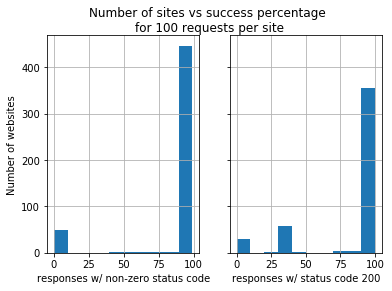

In [1059]:
f, axarr = plt.subplots(1,2, sharey=True)

axarr[0].hist(df_pivot['success_percent'])
axarr[0].set_xlabel("responses w/ non-zero status code")
axarr[0].set_ylabel("Number of websites")
axarr[0].grid(True)

axarr[1].hist(df_pivot2['pass_percent'])
axarr[1].set_xlabel("responses w/ status code 200")
#axarr[1].set_title("Number of sites for percentage of non-zero responses per site")
axarr[1].grid(True)

f.suptitle("Number of sites vs success percentage \nfor 100 requests per site")
f.savefig("results/curl_requests_response_rate_hist")

In [1086]:
d = df_pivot2[(df_pivot2['pass_percent']<35)].join(df_all.set_index('rank'))
google = d[ d['ASN']==15169 ].index

In [1087]:
df_timing[ df_timing['rank'].isin(google)].groupby(['response_code'])['rank'].count()

response_code
0        68
200    1917
302       1
403      99
404      99
503    3716
Name: rank, dtype: int64

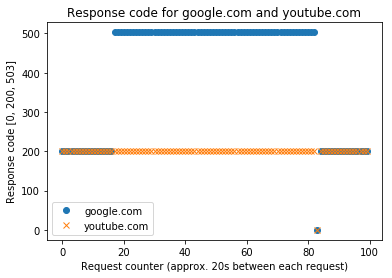

In [1088]:
f, ax = plt.subplots()
ax.plot( df_timing[ df_timing['rank']==1]['response_code'], 'o', label='google.com')
ax.plot( df_timing[ df_timing['rank']==2]['response_code'], 'x', label='youtube.com')
# convert index to seconds - every 500 requests wait for 20 s
labels=[int(l/500) for l in ax.get_xticks().tolist()]
ax.set_xticklabels(labels)
ax.set_title("Response code for google.com and youtube.com")
ax.set_xlabel("Request counter (approx. 20s between each request)")
ax.set_ylabel("Response code [0, 200, 503]")
ax.legend(loc='best')
f.savefig("results/curl_requests_google_response")

Total responses with status code 0 (Failed) =  5638
Total responses with status code 200 (OK) =  37470
Total responses with other status codes (Unreachable, Redirected, Forbidden, etc.) =  6892
Overall success rate = 0.7494


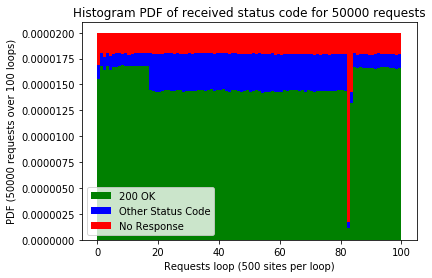

In [1089]:
data0 = [int(d) for d in df_timing[(df_timing['response_code']==0)]['response_code'].index ]
#x0,y0 = getCDF(data0)
data200 = [int(d) for d in df_timing[(df_timing['response_code']==200)]['response_code'].index ]
#x200,y200 = getCDF(data200)
dataother = [int(d) for d in df_timing[~(df_timing['response_code'].isin([0,200]))]['response_code'].index ]
#xother,yother = getCDF(dataother)

print("Total responses with status code 0 (Failed) = ", len(data0))
print("Total responses with status code 200 (OK) = ", len(data200))
print("Total responses with other status codes (Unreachable, Redirected, Forbidden, etc.) = ", len(dataother))
print("Overall success rate = %s" %(len(data200)/len(df_timing)))

f,ax = subplots()
ax.hist([data200,dataother,data0], 100, color=["green", "blue","red"], density = True, stacked=True)
ax.legend({'200 OK': "green", 'Other Status Code': "blue", 'No Response': "red"})
labels=[int(l/500) for l in ax.get_xticks().tolist()]
ax.set_xticklabels(labels)
ax.set_title("Histogram PDF of received status code for 50000 requests")
ax.set_xlabel("Requests loop (500 sites per loop)")
ax.set_ylabel("PDF (50000 requests over 100 loops)")
f.savefig("results/curl_requests_all_status_code_pdf_hist")

#### Filter the 49 unreachable sites

In [1093]:
# sites with at least one non-zero response
df_responses = df_timing[ (df_timing['status_fail']==False) ]

df_valid = df_timing[ df_timing['rank'].isin(df_responses['rank'].unique()) ]

In [1094]:
data0 = [int(d) for d in df_valid[(df_valid['response_code']==0)]['response_code'].index ]
#x0,y0 = getCDF(data0)
data200 = [int(d) for d in df_valid[(df_valid['response_code']==200)]['response_code'].index ]
#x200,y200 = getCDF(data200)
dataother = [int(d) for d in df_valid[~(df_valid['response_code'].isin([0,200]))]['response_code'].index ]
#xother,yother = getCDF(dataother)

print("Total responses with status code 0 (Failed) = ", len(data0))
print("Total responses with status code 200 (OK) = ", len(data200))
print("Total responses with other status codes (Unreachable, Redirected, Forbidden, etc.) = ", len(dataother))
print("Overall success rate = %s" %(len(data200)/len(df_valid)))

Total responses with status code 0 (Failed) =  738
Total responses with status code 200 (OK) =  37470
Total responses with other status codes (Unreachable, Redirected, Forbidden, etc.) =  6892
Overall success rate = 0.830820399113082


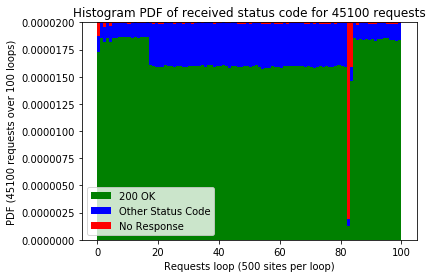

In [1095]:
f,ax = subplots()
ax.hist([data200,dataother,data0], 100, color=["green", "blue","red"], density = True, stacked=True)
ax.legend({'200 OK': "green", 'Other Status Code': "blue", 'No Response': "red"})
labels=[int(l/500) for l in ax.get_xticks().tolist()]
ax.set_xticklabels(labels)
ax.set_title("Histogram PDF of received status code for 45100 requests")
ax.set_xlabel("Requests loop (500 sites per loop)")
ax.set_ylabel("PDF (45100 requests over 100 loops)")
f.savefig("results/curl_requests_filtered_status_code_pdf_hist")

### SSL analysis
- We find out which site uses SSL by counting the difference of time between completion of the handshake and the last TCP packet. These timings are directly collected by CURL (from curl manpage):
    - time_appconnect The time, in seconds, it took from the start until the SSL/SSH/etc connect/handshake to the remote host was completed.
    - time_connect The time, in seconds, it took from the start until the TCP connect to the remote host (or proxy) was completed.
    - If time_appconnect - time_connect == 0 (or negative), we assume that SSL was not used.
- 44362 of 45100 requests received a non 0 status code in response (i.e. no failure).
- 40160 of 44362 valid responses used SSL, while 4202 did not use SSL
- Of 40160 ssl responses, 33433 had a status code 200 OK, 6727 had a status code other than 200 (but non-zero)
- Of 4202 non-ssl responses, 4037 responses had a status code 200, 165 had a status code other than 200.
- On checking we didn't find any pattern suggesting a particular period when SSL responses change.
- Based on CDF, about 45 websites have less than 20 requests that successfully use SSL. More than 90% websites successfully respond to HTTPS requests using SSL for almost all requests.
    - These 45 websites surprisingly include netflix.com, paypal.com, dailymail.co.uk, washingtonpost.com, playstation.com. This means that even though we used HTTPS, the server probably responded without SSL to load the home page.
    - To confirm we retested these 45 websites with our curl timing analysis code for just 20 requests.

In [1024]:
df_responses = df_valid[ (df_valid['status_fail']==False) ]

df_no_ssl = df_valid[ (df_valid['ssl_flag']==False) & (df_valid['status_fail']==False) ]
df_ssl = df_valid[ (df_valid['ssl_flag']==True) & (df_valid['status_fail']==False) ]

print( "Number of requests with non-zero status response:", len(df_responses) )
print( "Number of requests for which SSL was not used:", len(df_no_ssl) )
print( "Number of requests for which SSL was used:", len(df_ssl) )

df_responses.groupby(['ssl_flag', 'status_ok'])['rank'].count()

Number of requests with non-zero status response: 44362
Number of requests for which SSL was not used: 4202
Number of requests for which SSL was used: 40160


ssl_flag  status_ok
False     False          165
          True          4037
True      False         6727
          True         33433
Name: rank, dtype: int64

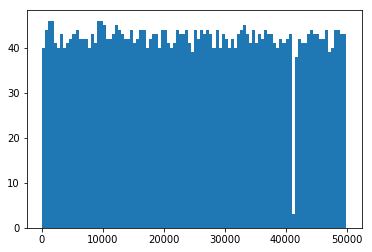

In [1025]:
i = hist( df_no_ssl.index, bins=100 )

In [1026]:
df_ssl_check = df_responses.groupby(['rank', 'ssl_flag'])['url_effective'].count().reset_index().pivot('rank','ssl_flag','url_effective').fillna(0)
df_ssl_check['ssl_success_rate'] = df_ssl_check[True]*100/(df_ssl_check[True]+df_ssl_check[False])


Text(0, 0.5, 'CDF (fraction of 451 total websites)')

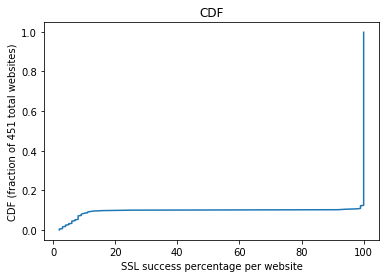

In [1027]:
xd, yd = getCDF( list(df_ssl_check['ssl_success_rate']) )
f,ax = subplots()
ax.plot(xd, yd)
ax.set_title("CDF")
ax.set_xlabel("SSL success percentage per website")
ax.set_ylabel("CDF (fraction of 451 total websites)")

In [1033]:
bad_ssl_site_indx = df_ssl_check[ df_ssl_check['ssl_success_rate'] < 20 ].index
bad_ssl_sites = df_asn_cdn[ df_asn_cdn['rank'].isin(bad_ssl_site_indx) ]

print ("Sites with bad SSL responses:\n", list( bad_ssl_sites['site'] ))

Sites with bad SSL responses:
 ['weibo.com', 'netflix.com', 'msn.com', 'paypal.com', 'thestartmagazine.com', 'zhihu.com', 'spotify.com', 'theguardian.com', 'avito.ru', 'vice.com', 'canva.com', 'patria.org.ve', 'wikihow.com', 'blogger.com', 'dailymail.co.uk', 'usps.com', 'mozilla.org', 'blackboard.com', 'ups.com', 'washingtonpost.com', 'zillow.com', 'weebly.com', 'weather.com', 'bet365.com', 'fedex.com', 'office365.com', 'doublepimp.com', 'orange.fr', 'fandom.com', 'americanexpress.com', 'oracle.com', 'cambridge.org', 'wiley.com', 'springer.com', 'samsung.com', 'namu.wiki', 'glassdoor.com', 'elsevier.com', 'skype.com', 'sberbank.ru', 'free.fr', 'bloomberg.com', 'cnbc.com', 'playstation.com', 'rarbg.to']


## 2b. Timings analysis for good responses (status code 200)
- We will only analyze those responses with status code 200, since other status codes might indicate that we never reached the site web page
- Since 4 websites had a success rate lower than 30%, we will remove them from the current analysis. These sites are ['reddit.com', 'amazon.de', 'amazon.co.uk', 'leboncoin.fr']

In [636]:
df_temp = df_timing[ ~df_timing['rank'].isin(bad_sites['site'].keys()) ]
df_filtered = df_temp[df_temp['response_code']==200]
df_redirected = df_temp[~df_temp['response_code'].isin([0,200])]

### Average timings per website
- average the calculated timings across all responses with a 200 status code

In [598]:
df_filtered.columns

Index(['response_code', 'size_download', 'size_header', 'size_request',
       'size_upload', 'url_effective', 'time_namelookup', 'time_connect',
       'time_appconnect', 'time_pretransfer', 'time_redirect',
       'time_starttransfer', 'time_total', 'rank', 't_dns', 'ssl_flag',
       't_ssl', 't_fbyte', 't_wait', 't_rx', 'size_up', 'size_dw', 'pass'],
      dtype='object')

In [599]:
df_filtered.groupby(['rank','ssl_flag'])[['size_up', 'size_dw', 't_dns',
       't_ssl', 't_fbyte', 't_wait', 't_rx']].mean()

,,size_up,size_dw,t_dns,t_ssl,t_fbyte,t_wait,t_rx
rank,ssl_flag,,,,,,,
1,True,76.000000,14567.060606,0.239854,9.872273e-02,0.456848,0.114397,0.001462
2,True,77.000000,428223.757576,0.008310,1.021042e-01,0.224925,0.109540,0.852680
3,True,78.000000,674018.818182,0.011994,2.040795e-01,0.775510,0.466500,0.630489
4,True,77.000000,2843.000000,0.054017,1.819955e-01,0.473341,0.129672,0.000079
5,True,79.000000,83995.989899,0.053500,1.848144e-01,0.426418,0.083558,0.188044
6,True,72.000000,236159.845361,1.671953,1.902289e-01,2.036760,0.089068,0.304014
7,True,154.000000,450646.428571,-0.441348,1.884625e-01,0.398409,0.112675,1.374084
8,True,76.000000,90742.069767,0.033693,6.861486e-02,0.600390,0.484145,0.959486
9,True,156.000000,244952.680851,-1.935363,9.649641e-01,1.165772,0.053857,2.212207
